# Aula 25 - Calibração de Câmera

Em aulas anteriores vimos que uma câmera pode ser representada por duas matrizes que modelam seus parâmetros intrínsecos e extrínsecos. O problema é que para os exercícios nós assumimos que esses parâmetros são conhecidos, mas no mundo real isso dificilmente acontece.

Nesta atividade aprenderemos como obter uma estimativa desses parâmetros através de um processo de calibração.

### Observações Importantes (leia antes de continuar!)

Muitas câmeras possuem uma opção de auto foco. Você deve **desabilitar o auto foco da sua câmera antes de realizar a calibração**. Caso contrário os parâmetros vão mudar a todo instante.

## Calibração com tabuleiros ChArUco

*ChArUco* é a união dos termos *chessboard* e *ArUco* e é essencialmente o que o nome diz: um tabuleiro de xadrez com marcadores ArUco. O tabuleiro ChArUco é utilizado por ser facilmente detectado em uma imagem e os marcadores são utilizados para aprimorar a detecção dos cantos.


![Tabuleiro ChArUCO](charucoboard.jpg)

O OpenCV já possui funções prontas para calibrar a câmera usando um tabuleiro ChArUco.


In [10]:
import os.path
import cv2
import matplotlib.pyplot as plt

## Intuição

Diferentemente das outras atividades, não vamos implementar a calibração "na mão", mas gostaria de apresentar uma breve intuição do processo de calibração. Como vimos anteriormente, a projeção de um ponto 3D na imagem de uma câmera pode ser representada por uma sequência de multiplicações de matrizes:

$$
\begin{pmatrix}
P'_x \\
P'_y \\
1
\end{pmatrix}
=
\begin{pmatrix}
f_x & 0 & p_x & 0 \\
0 & f_y & p_y & 0 \\
0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
E_{11} & E_{12} & E_{13} & E_{14} \\
E_{21} & E_{22} & E_{23} & E_{24} \\
E_{31} & E_{32} & E_{33} & E_{34} \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
P_x \\
P_y \\
P_z \\
1
\end{pmatrix}
$$

Onde $P'$ é o ponto na imagem, em pixels, $f$ é a distância focal, $p$ é o ponto principal, $E$ é a matriz de parâmetros extrínsecos e $P$ é o ponto em 3D que será projetado na imagem. Se multiplicarmos as matrizes de parâmetros intrínsecos e extrínsecos, temos:

$$
\begin{pmatrix}
P'_x \\
P'_y \\
1
\end{pmatrix}
=
\begin{pmatrix}
C_{11} & C_{12} & C_{13} & C_{14} \\
C_{21} & C_{22} & C_{23} & C_{24} \\
C_{31} & C_{32} & C_{33} & C_{34}
\end{pmatrix}
\begin{pmatrix}
P_x \\
P_y \\
P_z \\
1
\end{pmatrix}
$$

Onde $C$ é o resultado da multiplicação das duas matrizes. Se tivermos pares de pontos $P$ e $P'$ (pontos no espaço e a sua projeção na imagem) suficientes podemos montar um sistema de equações lineares como fizemos anteriormente para o cálculo de homografias.

Entretanto, como podemos obter esses pares de pontos? Aí que entram os tabuleiros ChArUco! Em um tabuleiro ChArUco sabemos a localização de cada canto de cada marcador e de cada quadrado. Então já temos a posição $P_x$ e $P_y$ de diversos pontos, mas e a coordenada $P_z$? O tabuleiro inteiro está contido em um mesmo plano. Então podemos usar a mesma coordenada $P_z = 0$ para todos eles. Assim, os parâmetros extrínsecos serão responsáveis por mover o tabuleiro no plano $XY$ para a sua posição com relação à câmera com centro de projeção na origem.

Ufa, acabamos! Se você não entendeu direito o que discutimos até aqui, não se preocupe! Talvez a prática com código ajude. Como eu disse antes, muito do que precisamos já está implementado em funções do OpenCV.

## Obtendo os pontos de referência 

O primeiro passo é obter os pontos de referência. Para isso, salve algumas imagens com o tabuleiro em diferentes posições e distâncias. Tente obter imagens distribuindo o tabuleiro o máximo possível em posições e orientações diferentes.

<img src="arucocalibration.png" alt="Fonte: https://docs.opencv.org/3.4.3/da/d13/tutorial_aruco_calibration.html"/>

**Exercício**: Capture 10 imagens com o tabuleiro *ChArUco* em posições diferentes. Salve-as com o nome `charuco-camera-{num}.png`. Capture as imagens com as seguintes guias:

1. diferentes distâncias
1. diferentes ângulos
1. diferentes posições na imagem (varie entre o tabuleiro centralizado e nos cantos da imagem). Você pode inclusive deixar uma parte do tabuleiro de fora.


Com as imagens feitas, nosso processo de calibração consiste em XX passos:

1. Configurar nosso board usando a função [cv2.aruco.CharucoBoard_create](https://docs.opencv.org/3.4.3/d0/d3c/classcv_1_1aruco_1_1CharucoBoard.html#aa83b0a885d4dd137a41686991f85594c). 
    * Usaremos o dicionário `cv2.aruco.DICT_6X6_50` (que precisa ser recuperado usando a função `cv2.getPredefinedDictionary`.
2. Usar a função [cv2.detectMarkers](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#gab9159aa69250d8d3642593e508cb6baa) para encontrar uma lista de marcadores na imagem.
3. Marcadores não precisam estar necessariamente em um *ChArUco*. Para pegar as bordas do tabuleiro usamos a função [cv2.interpolateCornersCharuco](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1).
4. Repetir o processo para todas as imagens do exercício anterior e guardar os cantos e os *ids* em listas. 
5. Usar a função [cv2.calibrateCamera](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1) para descobrir os parâmetros intrínsecos (`cameraMatrix`) e extrínsecos (`distCoeffs`) da câmera. A função também retorna os vetores `rvecs` e `tvecs`, que representam as posições do tabuleiro para cada imagem usada na calibração.

Com isto podemos pegar uma imagem qualquer e detectar a pose de marcadores individuais nela usando a função [estimatePoseSingleMarkers](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#ga84dd2e88f3e8c3255eb78e0f79571bd1) ou do tabuleiro inteiro usando [estimatePoseCharucoBoard](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#gab098ca624829bcbf7d9ebb8479887c3a).


---

Vamos começar agora nosso passo a passo para fazer a calibração da câmera. 

**Exercício**: Crie um objeto `board` usando as funções do OpenCV. Use o dicionário especificado na descrição acima. 

In [8]:


snap = 0

cap = cv2.VideoCapture(0)

_, frame = cap.read()
print(frame.shape)
while frame is not None:
    frame = frame[:, ::-1, :]
    
    frame_view = frame.copy()
    cv2.rectangle(frame_view, (220, 140), (420, 340), (0, 255, 0))
    cv2.imshow('frame', frame_view)
    

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        filename = f'charuco-camera-{snap:05d}.png' 
        cv2.imwrite(filename, frame)
        print(f'Saved {filename}')
        snap += 1

    _, frame = cap.read()

cap.release()
cv2.destroyAllWindows()

(720, 1280, 3)


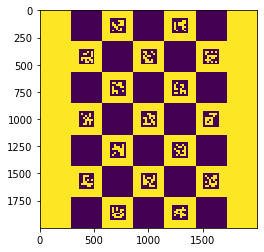

In [11]:
#plt.plot(cv2.getPredefinedDictionary(cv2.aruco.DICT_6X6_50))
#cv2.aruco.DICT_6X6_50
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
board = cv2.aruco.CharucoBoard_create(5,7,4, 2, aruco_dict)
imboard = board.draw((2000, 2000))

plt.imshow(imboard)

**Exercício**: Carregue uma das imagens de calibração e detecte os marcadores presentes nela usando a função `detectMarkers`. Use a função [drawDetectedMarkers](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#ga84dd2e88f3e8c3255eb78e0f79571bd1) para pintar na imagem os marcadores localizados.

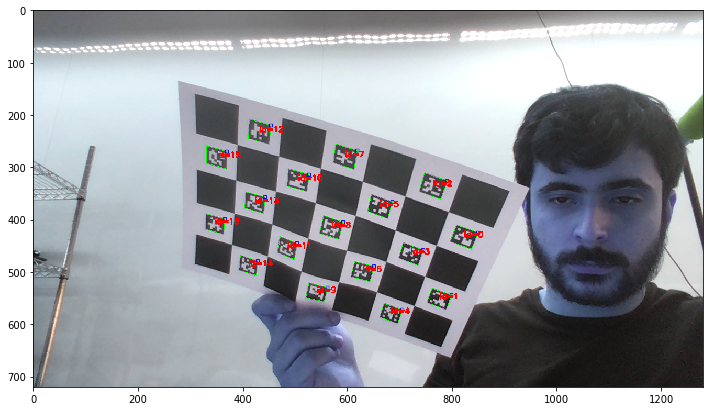

In [12]:
img = cv2.flip(cv2.imread('charuco-camera-00003.png'),1)
frame = img.copy()

corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)

imaxis = cv2.aruco.drawDetectedMarkers(frame, corners, ids)

plt.figure(figsize=(12,12))
plt.imshow(frame,cmap="gray")

**Exercício**: Com os marcadores (cantos e ids), use a função `interpolateCornersCharuco` para encontrar os cantos do tabuleiro. Novamente, use a função [drawDetectedCornersCharuco](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#ga2ad34b0f277edebb6a132d3069ed2909) para visualizar seu resultado.

[[793 385]
 [390 257]
 [380 447]
 [728 564]]
(24, 1, 2)
(4, 1, 2)


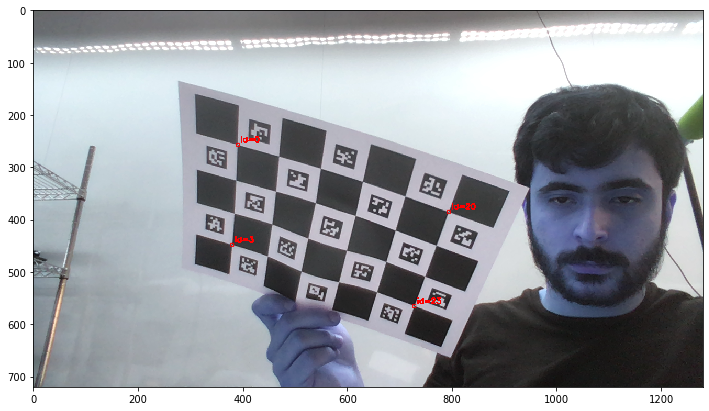

In [13]:
import numpy as np
frame2 = img.copy()

#corners, ids, rejectedImgPoints = cv2.aruco.interpolateCornersCharuco(frame, aruco_dict)
res = cv2.aruco.interpolateCornersCharuco(corners,ids,frame2,board)
#print(res)
#cv2.aruco.drawDetectedMarkers(frame2,res[0],res[1])

pos4c= np.array([res[1][0],res[1][20],res[1][3],res[1][23]])
id4c = np.array([res[2][0],res[2][20],res[2][3],res[2][23]])

posPoly = np.array([res[1][20],res[1][0],res[1][3],res[1][23]],np.int32)[:,0]
print(posPoly)


cv2.aruco.drawDetectedCornersCharuco(frame2,pos4c,id4c)

print(res[1].shape)
print(pos4c.shape)

plt.figure(figsize=(12,12))
plt.imshow(frame2,cmap="gray")

In [14]:
frame2.shape

(720, 1280, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[390.52713 257.1928 ]]

 [[793.8125  385.39316]]

 [[380.17212 447.8928 ]]

 [[728.30536 564.69086]]]


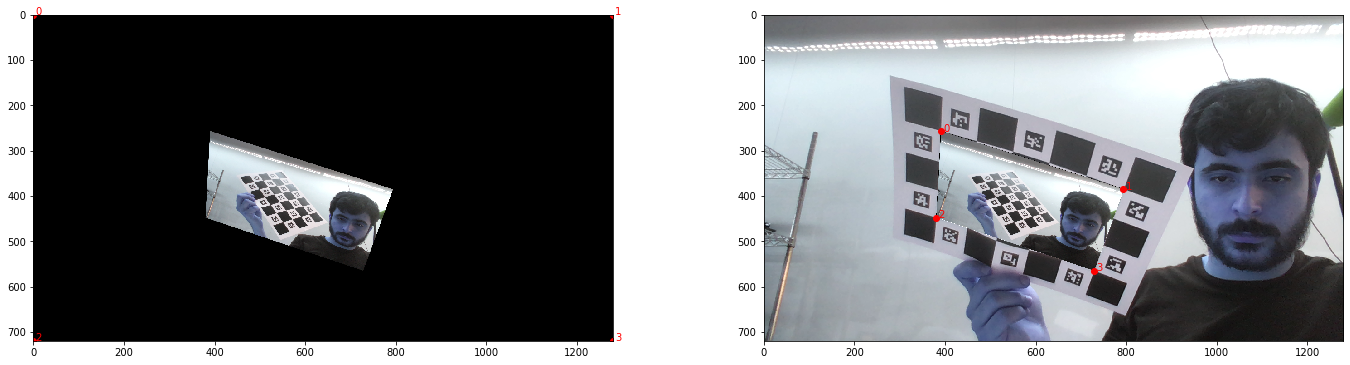

In [15]:


over = cv2.flip(cv2.imread('charuco-camera-00001.png'),1)


rows, cols,_ = img.shape

res = cv2.aruco.interpolateCornersCharuco(corners,ids,img,board)


pos4c= np.array([res[1][0],res[1][20],res[1][3],res[1][23]])
id4c = np.array([res[2][0],res[2][20],res[2][3],res[2][23]])

posPoly = np.array([res[1][20],res[1][0],res[1][3],res[1][23]],np.int32)[:,0]

pts_original = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows -1]]) # pos4c #np.float32([[132,125],[230,132],[132,162],[230,170]])
pts_corrigida = pos4c #np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows -1]])

print(pos4c)
# print(pts_original)
# print(pts_corrigida)

#corners, ids, rejectedImgPoints = cv2.aruco.interpolateCornersCharuco(frame, aruco_dict)
#print(res)
#cv2.aruco.drawDetectedMarkers(frame2,res[0],res[1])




M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

img_corrigida = cv2.warpPerspective(over, M, (cols, rows))

#print(np.array([[10,30], [40,80], [10,90]], np.int32))
#print(np.array(pos4c[:,0], np.int32))

back = np.zeros(img.shape, np.int32)
cv2.fillConvexPoly(back,np.array(posPoly, np.int32),[255, 255, 255])

back_i = (255-back)

#print(back_i.shape,img.shape,back.shape)
#print(back_i)
#print(img)
# cv2.bitwise_and(back_i,img)
# cv2.bitwise_not(background)
#img.copy()

plt.figure(figsize=(24,6))
plt.subplot(121)
plt.imshow(img_corrigida, cmap='gray')
for k, p in enumerate(pts_original):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')

plt.subplot(122)

plt.imshow((back_i & img)+img_corrigida, cmap='gray')
for k, p in enumerate(pts_corrigida):
    plt.plot([p[0][0]], [p[0][1]], 'ro')
    plt.text(p[0][0] + 5, p[0][1], str(k), color='red')
plt.show()

Os exercícios acima realizam os passos 1, 2 e 3 do processo de calibração. 

**Exercício**: repita os passos acima para todas as imagens de calibração e guarde os resultados em uma lista de cantos e uma lista de ids. 

In [16]:
n=10

listCorners, listIDs = [],[]
for i in range(n):
    img = cv2.flip(cv2.imread('charuco-camera-0000{}.png'.format(i)),1)
    frame = img.copy()
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)
    res = cv2.aruco.interpolateCornersCharuco(corners,ids,frame,board)
    listCorners.append(res[1])
    listIDs.append(res[2])
    print(i)

    

0
1
2
3
4
5
6
7
8
9


**Exercício**: use os resultados acima para chamar a função `calibrateCamera`. Os parâmetros `cameraMatrix` e `distCoeffs` são passados como `None` pois serão retornados pela função. 

In [17]:
cameraMatrix, distCoeffs = None,None
imgSize = ()


(ret, cameraMatrix, distCoeffs,rotation_vectors, translation_vectors) = cv2.aruco.calibrateCameraCharuco(listCorners,listIDs,board,(720,1280),cameraMatrix,distCoeffs)


**Exercício**: escolha uma das imagens de calibração, use as funções `detectMarkers` e `interpolateCornersCharuco` para encontrar os cantos do tabuleiro e a função `estimatePoseCharucoBoard` para estimar a posição e orientação do tabuleiro.

In [18]:
img = cv2.flip(cv2.imread('charuco-camera-0000{}.png'.format(4)),1)

frame3 = img.copy()
print(frame3.shape)
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame3, aruco_dict)
res = cv2.aruco.interpolateCornersCharuco(corners,ids,frame3,board)
rvec, tvec = None,None

retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(res[1],res[2],board,cameraMatrix,distCoeffs,rvec,tvec)



(720, 1280, 3)


Os valores `rvec` e `tvec` retornados por esta função representam a transformação leva o tabuleiro a origem.

**Exercício**: use a função [drawAxis](https://docs.opencv.org/3.4.3/d9/d6a/group__aruco.html#ga16fda651a4e6a8f5747a85cbb6b400a2) para desenhar na imagem a orientação e origem do sistema de coordenadas do plano do tabuleiro. 

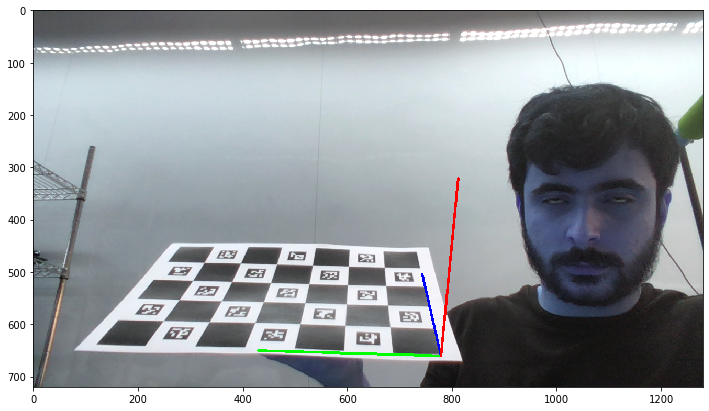

In [19]:
imaxis = cv2.aruco.drawAxis(frame3, cameraMatrix, distCoeffs, rvec, tvec, 15)

plt.figure(figsize=(12,12))
plt.imshow(imaxis,cmap="gray")

In [7]:
import os.path
import cv2
import numpy as np

def calibrate_camera():
    n=10
    listCorners, listIDs = [],[]
    for i in range(n):
        img = cv2.flip(cv2.imread('charuco-camera-0000{}.png'.format(i)),1)
        frame = img.copy()
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)
        res = cv2.aruco.interpolateCornersCharuco(corners,ids,frame,board)
        listCorners.append(res[1])
        listIDs.append(res[2])
        print(i)
        
        return cv2.aruco.calibrateCameraCharuco(listCorners,listIDs,board,(720,1280),cameraMatrix,distCoeffs)


aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
board = cv2.aruco.CharucoBoard_create(5,7,4, 2, aruco_dict)

#(ret, cameraMatrix, distCoeffs,rotation_vectors, translation_vectors) = cv2.aruco.calibrateCameraCharuco(listCorners,listIDs,board,(720,1280),cameraMatrix,distCoeffs)
(ret, cameraMatrix, distCoeffs,rotation_vectors, translation_vectors) = calibrate_camera()

def get_markers(img):
    frame = img.copy()
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)
    return corners, ids, rejectedImgPoints

def make_axis(res1,res2):
    rvec, tvec = None,None
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(res[1],res[2],board,cameraMatrix,distCoeffs,rvec,tvec)
    return cameraMatrix, distCoeffs, rvec, tvec

snap = 0

over = cv2.flip(cv2.imread('charuco-camera-00001.png'),1)


rows, cols,_ = over.shape

pts_original = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows -1]]) # pos4c #np.float32([[132,125],[230,132],[132,162],[230,170]])


cap = cv2.VideoCapture(0)


_, frame = cap.read()
print(frame.shape)
while frame is not None:
    frame = frame[:, ::-1, :]
    
    frame_view = cv2.flip(frame.copy(),1)
    frame_plane = frame_view.copy()
    
    
    corners, ids, rejectedImgPoints = get_markers(frame_view)
    
    #corners, ids, rejectedImgPoints = cv2.aruco.interpolateCornersCharuco(frame, aruco_dict)
    if ids is not None:
        #print(ids)
        li = len(ids)
        #print("Quantidade de markers: {}".format(len(ids)))
    
    try:
        res = cv2.aruco.interpolateCornersCharuco(corners,ids,frame_view,board)
        #print(res)
        #cv2.aruco.drawDetectedMarkers(frame2,res[0],res[1])

        pos4c= np.array([res[1][0],res[1][20],res[1][3],res[1][23]])
        id4c = np.array([res[2][0],res[2][20],res[2][3],res[2][23]])

        posPoly = np.array([res[1][20],res[1][0],res[1][3],res[1][23]],np.int32)[:,0]
        #print(posPoly)
        
        pts_corrigida = pos4c #np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows -1]])
        


        imaxis = cv2.aruco.drawDetectedCornersCharuco(frame_view,pos4c,id4c)
        
        cameraMatrix, distCoeffs, rvec, tvec = make_axis(res[1],res[2])
        

        imaxis = cv2.aruco.drawAxis(frame_view, cameraMatrix, distCoeffs, rvec, tvec, 15)
        #print(cameraMatrix)
        if len(cameraMatrix) == 3:
            
            M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

            img_corrigida = cv2.warpPerspective(over, M, (cols, rows))

            mask = img_corrigida == 0 # (255-back)
            temp_frame = frame_plane.copy()
            frame_plane = temp_frame*mask+img_corrigida #(back_i & temp_frame)+img_corrigida
            
            print("Detectado")


    except Exception as e: 
        print(e)
    imaxis = cv2.aruco.drawDetectedMarkers(frame_view, corners, ids)
    
    
    cv2.imshow('frame', imaxis)
    cv2.imshow('frame_plane', frame_plane)
    

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    _, frame = cap.read()

cap.release()
cv2.destroyAllWindows()

0
(720, 1280, 3)
OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/aruco/src/charuco.cpp:490: error: (-215:Assertion failed) _markerCorners.total() == _markerIds.getMat().total() && _markerIds.getMat().total() > 0 in function '_interpolateCornersCharucoLocalHom'

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/aruco/src/charuco.cpp:490: error: (-215:Assertion failed) _markerCorners.total() == _markerIds.getMat().total() && _markerIds.getMat().total() > 0 in function '_interpolateCornersCharucoLocalHom'

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/aruco/src/charuco.cpp:490: error: (-215:Assertion failed) _markerCorners.total() == _markerIds.getMat().total() && _markerIds.getMat().total() > 0 in function '_interpolateCornersCharucoLocalHom'

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/aruco/src/charuco.cpp:490: error: (-215:Assertion failed) _markerCorners.total()

O final da sua atividade deve ser parecido com a imagem abaixo. 

<img src="chaxis.png">

### Desafio 1 

Use as funções das partes 1, 2 e 3 para calcular uma homografia entre a imagem do charuco e uma imagem capturada por sua câmera. Após fazer isto, plote uma imagem em cima do tabuleiro.

### Desafio 2

Carregue o objeto da atividade da segunda aula (`teapot.obj`) e mostre-o sobre o tabuleiro utilizando a pose estimada pelo OpenCV. A função `cv2.projectPoints` pode ser útil para esse desafio.

<img src="example.png">

## Referências

- Multiple View Geometry in Computer Vision. Hartley, R. e Zisserman, A. Capítulo 7.
- Computer Vision. Szeliski, R. Capítulo 6.
- https://docs.opencv.org/3.1.0/df/d4a/tutorial_charuco_detection.html
- https://docs.opencv.org/3.4.3/da/d13/tutorial_aruco_calibration.html
- http://answers.opencv.org/question/98447/camera-calibration-using-charuco-and-python/

Algumas imagens utilizadas foram extraídas de: https://docs.opencv.org/3.1.0/df/d4a/tutorial_charuco_detection.html